EAR: 0.36
Lip Distance: 10.33


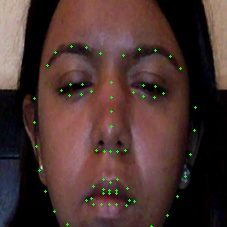

In [13]:
import cv2
import dlib
import numpy as np
from scipy.spatial import distance as dist
from imutils import face_utils
from IPython.display import Image, display

# -------- Config -------- #
image_path = "nn.png"  # Uploaded image
predictor_path = "shape_predictor_68_face_landmarks.dat"  # Uploaded model file

# -------- Helper Functions -------- #
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def lip_distance(shape):
    top_lip = np.concatenate((shape[50:53], shape[61:64]))
    low_lip = np.concatenate((shape[56:59], shape[65:68]))
    return abs(np.mean(top_lip, axis=0)[1] - np.mean(low_lip, axis=0)[1])

# -------- Load model -------- #
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# -------- Load and check image -------- #
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found or not loaded: {image_path}")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)

# -------- Process Faces -------- #
for rect in rects:
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEAR = eye_aspect_ratio(shape[lStart:lEnd])
    rightEAR = eye_aspect_ratio(shape[rStart:rEnd])
    ear = (leftEAR + rightEAR) / 2.0

    distance = lip_distance(shape)

    print(f"EAR: {ear:.2f}")
    print(f"Lip Distance: {distance:.2f}")

    if ear < 0.3:
        print("⚠️ Drowsiness Detected!")
    if distance > 20:
        print("😮 Yawn Detected!")

    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)

# -------- Output -------- #
cv2.imwrite("output.jpg", image)
display(Image("output.jpg"))


In [5]:
!pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=93d2845bed2591a9f5c5678ce277443146c1acdd59b127700195608de3983fba
  Stored in directory: /root/.cache/pip/wheels/50/98/42/62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound


-> Loading the predictor and detector...
-> Found 4 images for testing
Processing image: /content/test/L0296.png


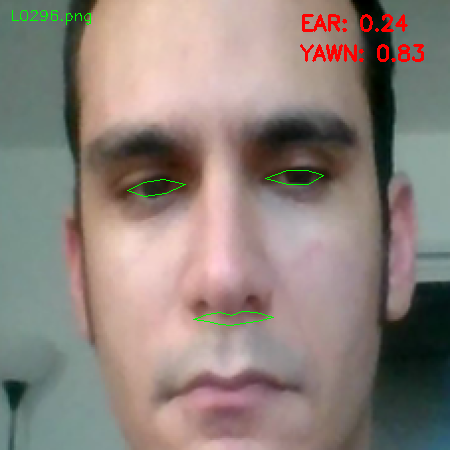

Processing image: /content/test/I0649.png


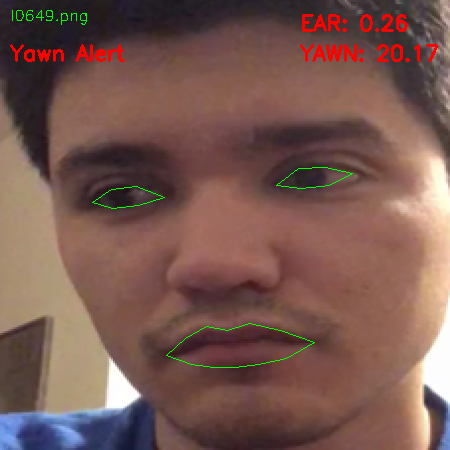

Processing image: /content/test/K0039.png


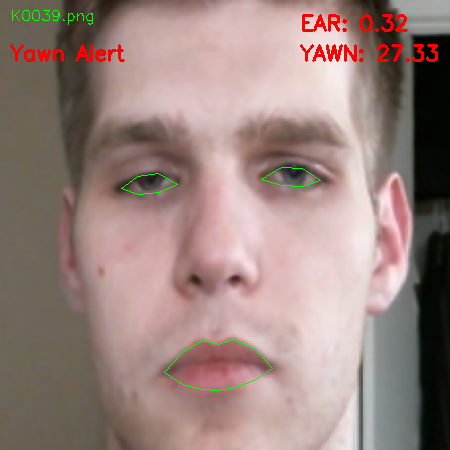

Processing image: /content/test/I1019.png


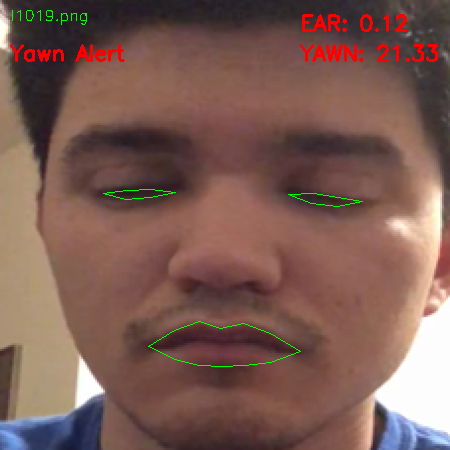

Processing complete!


In [9]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
import playsound
import os
import glob  # For finding image files

def sound_alarm(path):
    global alarm_status
    global alarm_status2
    global saying

    while alarm_status:
        print('call')
        playsound.playsound(path)
    if alarm_status2:
        print('call')
        saying = True
        playsound.playsound(path)
        saying = False

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# For Google Colab, use a direct path instead of command line arguments
image_dir = "/content/test"  # Path to your test images folder
alarm_path = "alert.mp4"  # Default alarm path

EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 30
YAWN_THRESH = 20
alarm_status = False
alarm_status2 = False
saying = False
COUNTER = 0

print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Get all image files from the specified directory
image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
              glob.glob(os.path.join(image_dir, "*.png"))

if len(image_paths) == 0:
    print(f"No images found in the directory: {image_dir}")
    print("Please make sure the directory exists and contains JPG or PNG images.")
    # List available directories to help debugging
    print("Available directories in current location:")
    print(os.listdir("."))
    exit()

print(f"-> Found {len(image_paths)} images for testing")

for image_path in image_paths:
    print(f"Processing image: {image_path}")

    # Read the image
    frame = cv2.imread(image_path)
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                     minNeighbors=5, minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE)

    # Draw filename on image
    cv2.putText(frame, os.path.basename(image_path), (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    for (x, y, w, h) in rects:
        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        eye = final_ear(shape)
        ear = eye[0]
        leftEye = eye[1]
        rightEye = eye[2]

        distance = lip_distance(shape)

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        lip = shape[48:60]
        cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

        # Simulate frame counter for drowsiness detection
        if ear < EYE_AR_THRESH:
            COUNTER += 1
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        else:
            COUNTER = 0

        if (distance > YAWN_THRESH):
            cv2.putText(frame, "Yawn Alert", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # In Google Colab, we need to use cv2_imshow instead of cv2.imshow
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)

    # Wait for a key press - in Colab this works differently
    # We'll add a small delay instead
    time.sleep(2)

print("Processing complete!")

In [ ]:
!pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=d1ec12aa3525a16f2270ff6e714d3977402bcd8ddf07824d9fd6ec43c5fc24c4
  Stored in directory: /root/.cache/pip/wheels/50/98/42/62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound


-> Loading the predictor and detector...
-> Found 4 images for testing

Processing image: /content/test/L0296.png


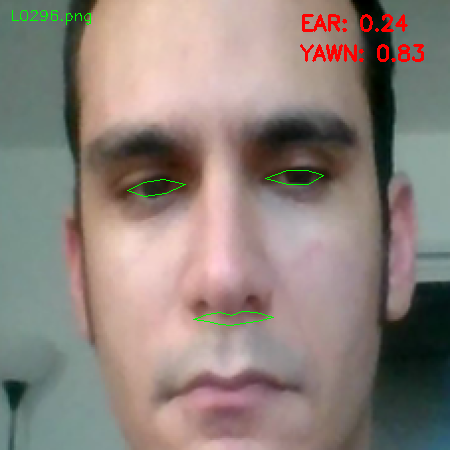


Processing image: /content/test/I0649.png


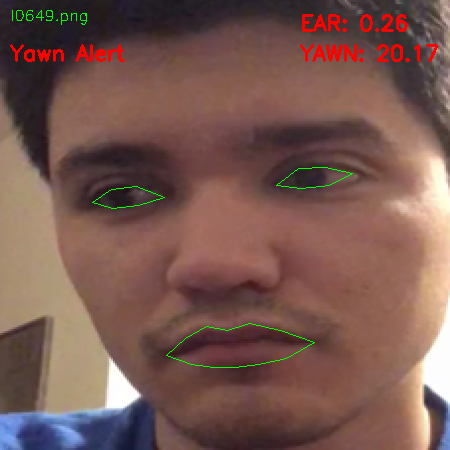

⚠️ ALERT: Drowsiness/Yawn detected!



Processing image: /content/test/K0039.png


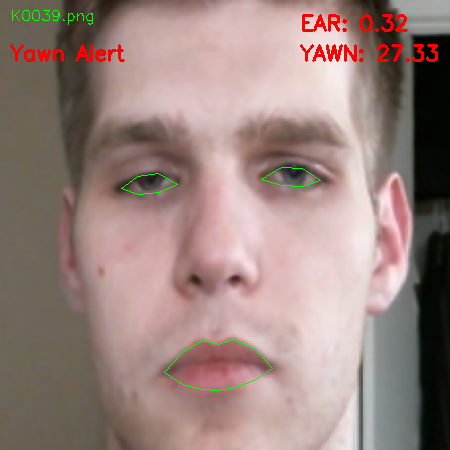

⚠️ ALERT: Drowsiness/Yawn detected!



Processing image: /content/test/I1019.png


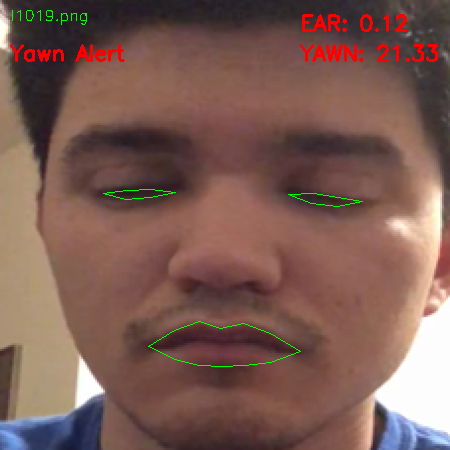

⚠️ ALERT: Drowsiness/Yawn detected!


Processing complete!


In [18]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display
import glob

# Function to play alert sound in Colab
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# For Google Colab, use a direct path instead of command line arguments
image_dir = "/content/test"  # Path to your test images folder

# Set your custom alert sound file path here
# You'll need to upload your sound file to Colab or download it from a URL
custom_alert_path = "/content/alert.mp4"  # Change this to your file's path

# Download a sample alert sound if you don't have one
# Uncomment the following line to download a sample alert sound
# !wget -O "/content/custom_alert.mp3" "https://example.com/path-to-your-alert-sound.mp3"

# Or upload a file through Colab's file browser and set the path accordingly

EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 30
YAWN_THRESH = 20
alarm_status = False
alarm_status2 = False
COUNTER = 0

print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Get all image files from the specified directory
image_paths = glob.glob(os.path.join(image_dir, "*.jpg")) + \
              glob.glob(os.path.join(image_dir, "*.png"))

if len(image_paths) == 0:
    print(f"No images found in the directory: {image_dir}")
    print("Please make sure the directory exists and contains JPG or PNG images.")
    # List available directories to help debugging
    print("Available directories in current location:")
    print(os.listdir("."))
    exit()

print(f"-> Found {len(image_paths)} images for testing")

for image_path in image_paths:
    print(f"\nProcessing image: {image_path}")

    # Read the image
    frame = cv2.imread(image_path)
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                     minNeighbors=5, minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE)

    # Draw filename on image
    cv2.putText(frame, os.path.basename(image_path), (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    alert_triggered = False

    for (x, y, w, h) in rects:
        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        eye = final_ear(shape)
        ear = eye[0]
        leftEye = eye[1]
        rightEye = eye[2]

        distance = lip_distance(shape)

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        lip = shape[48:60]
        cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

        # Simulate frame counter for drowsiness detection
        if ear < EYE_AR_THRESH:
            COUNTER += 1
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                alert_triggered = True
        else:
            COUNTER = 0

        if (distance > YAWN_THRESH):
            cv2.putText(frame, "Yawn Alert", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            alert_triggered = True

        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # In Google Colab, we need to use cv2_imshow instead of cv2.imshow
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)

    # Play alert if triggered and custom alert file exists
    if alert_triggered and os.path.exists(custom_alert_path):
        play_alert_in_colab(custom_alert_path)

    # Small delay between images
    time.sleep(2)

print("Processing complete!")

-> Loading the predictor and detector...
Detected EAR: 0.1238, Threshold: 0.2500
Detected lip distance: 21.3333, Threshold: 25.0000

Processing image: /content/nn.png
Detected 1 face(s) in the image.
Yawn detected! Lip Distance: 30.67


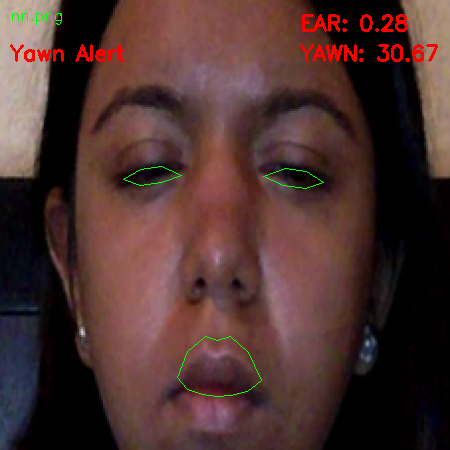

⚠️ ALERT: Drowsiness/Yawn detected!


Processing complete!


In [11]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display

# Function to play alert sound in Colab
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# Single image path to process
image_path = "/content/nn.png"  # Change this to your specific image path

# Set your custom alert sound file path here
custom_alert_path = "/content/alert.mp4"  # Change this to your file's path

# Download a sample alert sound if you don't have one
# Uncomment the following line to download a sample alert sound
# !wget -O "/content/custom_alert.mp3" "https://example.com/path-to-your-alert-sound.mp3"

EYE_AR_THRESH = 0.25
EYE_AR_CONSEC_FRAMES = 30
YAWN_THRESH = 25
COUNTER = 0

print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

print(f"Detected EAR: {ear:.4f}, Threshold: {EYE_AR_THRESH:.4f}")
print(f"Detected lip distance: {distance:.4f}, Threshold: {YAWN_THRESH:.4f}")

# Check if image exists
if not os.path.exists(image_path):
    print(f"Image not found at: {image_path}")
    print("Please make sure the image exists at the specified path.")
    exit()

print(f"\nProcessing image: {image_path}")

# Read the image
frame = cv2.imread(image_path)
if frame is None:
    print(f"Failed to read image from: {image_path}")
    print("The file may be corrupted or in an unsupported format.")
    exit()

frame = imutils.resize(frame, width=450)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces
rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                 minNeighbors=5, minSize=(30, 30),
                                 flags=cv2.CASCADE_SCALE_IMAGE)

# Draw filename on image
cv2.putText(frame, os.path.basename(image_path), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

alert_triggered = False

if len(rects) == 0:
    print("No faces detected in the image.")
else:
    print(f"Detected {len(rects)} face(s) in the image.")

for (x, y, w, h) in rects:
    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    eye = final_ear(shape)
    ear = eye[0]
    leftEye = eye[1]
    rightEye = eye[2]

    distance = lip_distance(shape)

    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)
    cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
    cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

    lip = shape[48:60]
    cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

    # Check for drowsiness
    if ear < EYE_AR_THRESH:
        cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        alert_triggered = True
        print(f"Drowsiness detected! Eye Aspect Ratio: {ear:.2f}")

    # Check for yawn
    if distance > YAWN_THRESH:
        cv2.putText(frame, "Yawn Alert", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        alert_triggered = True
        print(f"Yawn detected! Lip Distance: {distance:.2f}")

    cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# In Google Colab, we need to use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow
cv2_imshow(frame)

# Play alert if triggered and custom alert file exists
if alert_triggered and os.path.exists(custom_alert_path):
    play_alert_in_colab(custom_alert_path)
else:
    print("No alert triggered or alert sound file not found.")

print("Processing complete!")

-> Loading the predictor and detector...

Processing image: /content/nn.png
Detected 1 face(s) in the image.
Detected EAR: 0.2792, Normal Threshold: 0.2500, Emergency Threshold: 0.2000
Detected lip distance: 30.6667, Normal Threshold: 30.0000, Emergency Threshold: 20.0000
EMERGENCY! Extreme yawning detected! Lip Distance: 30.67


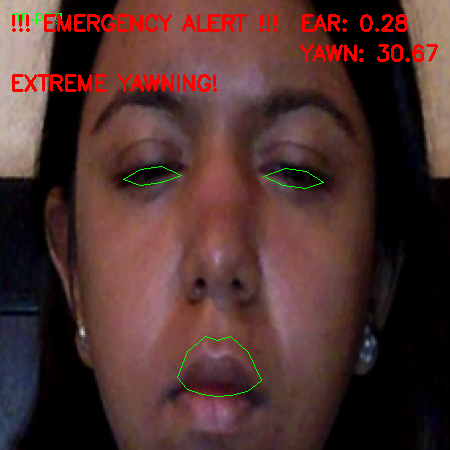

🚨 EMERGENCY ALERT TRIGGERED! 🚨


Processing complete!


In [17]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display

# Function to play alert sound in Colab
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

# Function for emergency alert
def trigger_emergency_alert():
    print("🚨 EMERGENCY ALERT TRIGGERED! 🚨")

    # Option 1: Display a very visible alert in the notebook
    from IPython.display import HTML, display
    emergency_html = """
    <div style="background-color: red; color: white; padding: 20px; font-size: 24px; text-align: center; animation: blinker 1s linear infinite;">
    ⚠️ EMERGENCY! DRIVER SEVERELY DROWSY! TAKE IMMEDIATE ACTION! ⚠️
    </div>
    <style>
    @keyframes blinker {
      50% {
        opacity: 0;
      }
    }
    </style>
    """
    display(HTML(emergency_html))

    # Option 2: Play a loud emergency sound
    emergency_sound_path = "/content/emergency_alert.mp3"
    if os.path.exists(emergency_sound_path):
        display(Audio(emergency_sound_path, autoplay=True))

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# Single image path to process
image_path = "/content/nn.png"  # Change this to your specific image path

# Set your custom alert sound file path here
normal_alert_path = "/content/alert.mp3"  # For regular alerts
emergency_alert_path = "/content/emergency_alert.mp3"  # For emergency situations

# First install pydub - you need to run this first
!pip install pydub

# Then generate the emergency sound
from pydub import AudioSegment
from pydub.generators import Sine

# Generate a regular alert sound
beep = Sine(440).to_audio_segment(duration=1000)
beep = beep * 3  # Make it louder
beep.export("/content/alert.mp3", format="mp3")

# Generate a more urgent emergency sound
emergency = Sine(880).to_audio_segment(duration=300)
emergency = emergency * 4  # Make it even louder
for _ in range(5):  # Repeat the tone for urgency
    emergency += Sine(988).to_audio_segment(duration=300) * 4
emergency.export("/content/emergency_alert.mp3", format="mp3")

# Parameters for normal and emergency thresholds
EYE_AR_THRESH = 0.25  # Normal drowsiness threshold
EMERGENCY_EYE_AR_THRESH = 0.2  # Severe drowsiness threshold
YAWN_THRESH = 30  # Normal yawn threshold
EMERGENCY_YAWN_THRESH = 20  # Very large yawn threshold
COUNTER = 0

print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Check if image exists
if not os.path.exists(image_path):
    print(f"Image not found at: {image_path}")
    print("Please make sure the image exists at the specified path.")
    exit()

print(f"\nProcessing image: {image_path}")

# Read the image
frame = cv2.imread(image_path)
if frame is None:
    print(f"Failed to read image from: {image_path}")
    print("The file may be corrupted or in an unsupported format.")
    exit()

frame = imutils.resize(frame, width=450)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces
rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                 minNeighbors=5, minSize=(30, 30),
                                 flags=cv2.CASCADE_SCALE_IMAGE)

# Draw filename on image
cv2.putText(frame, os.path.basename(image_path), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

normal_alert_triggered = False
emergency_alert_triggered = False

if len(rects) == 0:
    print("No faces detected in the image.")
else:
    print(f"Detected {len(rects)} face(s) in the image.")

for (x, y, w, h) in rects:
    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    eye = final_ear(shape)
    ear = eye[0]
    leftEye = eye[1]
    rightEye = eye[2]

    distance = lip_distance(shape)

    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)
    cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
    cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

    lip = shape[48:60]
    cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

    # Debug values
    print(f"Detected EAR: {ear:.4f}, Normal Threshold: {EYE_AR_THRESH:.4f}, Emergency Threshold: {EMERGENCY_EYE_AR_THRESH:.4f}")
    print(f"Detected lip distance: {distance:.4f}, Normal Threshold: {YAWN_THRESH:.4f}, Emergency Threshold: {EMERGENCY_YAWN_THRESH:.4f}")

    # Check for emergency conditions first (higher priority)
    if ear < EMERGENCY_EYE_AR_THRESH or distance > EMERGENCY_YAWN_THRESH:
        cv2.putText(frame, "!!! EMERGENCY ALERT !!!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        emergency_alert_triggered = True

        if ear < EMERGENCY_EYE_AR_THRESH:
            print(f"EMERGENCY! Severe drowsiness detected! Eye Aspect Ratio: {ear:.2f}")
            cv2.putText(frame, "SEVERE DROWSINESS!", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        if distance > EMERGENCY_YAWN_THRESH:
            print(f"EMERGENCY! Extreme yawning detected! Lip Distance: {distance:.2f}")
            cv2.putText(frame, "EXTREME YAWNING!", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Check for normal alert conditions
    elif ear < EYE_AR_THRESH or distance > YAWN_THRESH:
        normal_alert_triggered = True

        if ear < EYE_AR_THRESH:
            cv2.putText(frame, "Drowsiness Alert", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Drowsiness detected! Eye Aspect Ratio: {ear:.2f}")

        if distance > YAWN_THRESH:
            cv2.putText(frame, "Yawn Alert", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Yawn detected! Lip Distance: {distance:.2f}")

    cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# In Google Colab, we need to use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow
cv2_imshow(frame)

# Handle alerts based on priority
if emergency_alert_triggered:
    trigger_emergency_alert()
elif normal_alert_triggered and os.path.exists(normal_alert_path):
    play_alert_in_colab(normal_alert_path)
else:
    print("No alert triggered or alert sound files not found.")

print("Processing complete!")

-> Loading the predictor and detector...

Processing image: /content/nn.png
Detected 1 face(s) in the image.
Detected EAR: 0.1715, Normal Threshold: 0.2000, Emergency Threshold: 0.1000
Detected lip distance: 31.0000, Normal Threshold: 25.0000, Emergency Threshold: 10.0000
EMERGENCY! Extreme yawning detected! Lip Distance: 31.00


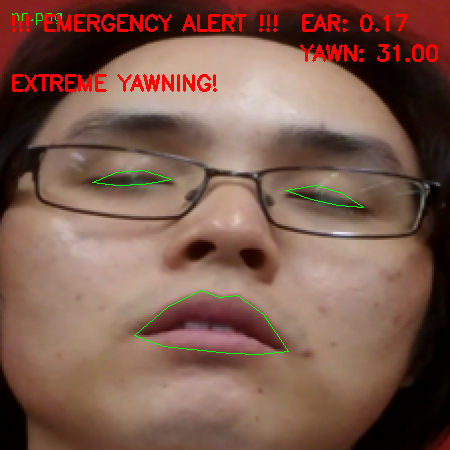

🚨 EMERGENCY ALERT TRIGGERED! 🚨


Processing complete!


In [18]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display

# Function to play alert sound in Colab
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

# Function for emergency alert
def trigger_emergency_alert():
    print("🚨 EMERGENCY ALERT TRIGGERED! 🚨")

    # Option 1: Display a very visible alert in the notebook
    from IPython.display import HTML, display
    emergency_html = """
    <div style="background-color: red; color: white; padding: 20px; font-size: 24px; text-align: center; animation: blinker 1s linear infinite;">
    ⚠️ EMERGENCY! DRIVER SEVERELY DROWSY! TAKE IMMEDIATE ACTION! ⚠️
    </div>
    <style>
    @keyframes blinker {
      50% {
        opacity: 0;
      }
    }
    </style>
    """
    display(HTML(emergency_html))

    # Option 2: Play a loud emergency sound
    emergency_sound_path = "/content/emergency_alert.mp3"
    if os.path.exists(emergency_sound_path):
        display(Audio(emergency_sound_path, autoplay=True))

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# Single image path to process
image_path = "/content/nn.png"  # Change this to your specific image path

# Set your custom alert sound file path here
normal_alert_path = "/content/alert.mp3"  # For regular alerts
emergency_alert_path = "/content/emergency_alert.mp3"  # For emergency situations

# First install pydub - you need to run this first
!pip install pydub

# Then generate the emergency sound
from pydub import AudioSegment
from pydub.generators import Sine

# Generate a regular alert sound
beep = Sine(440).to_audio_segment(duration=1000)
beep = beep * 3  # Make it louder
beep.export("/content/alert.mp3", format="mp3")

# Generate a more urgent emergency sound
emergency = Sine(880).to_audio_segment(duration=300)
emergency = emergency * 4  # Make it even louder
for _ in range(5):  # Repeat the tone for urgency
    emergency += Sine(988).to_audio_segment(duration=300) * 4
emergency.export("/content/emergency_alert.mp3", format="mp3")

# Parameters for normal and emergency thresholds
EYE_AR_THRESH = 0.2  # Normal drowsiness threshold
EMERGENCY_EYE_AR_THRESH = 0.1  # Severe drowsiness threshold
YAWN_THRESH = 25  # Normal yawn threshold
EMERGENCY_YAWN_THRESH = 10  # Very large yawn threshold
COUNTER = 0

print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Check if image exists
if not os.path.exists(image_path):
    print(f"Image not found at: {image_path}")
    print("Please make sure the image exists at the specified path.")
    exit()

print(f"\nProcessing image: {image_path}")

# Read the image
frame = cv2.imread(image_path)
if frame is None:
    print(f"Failed to read image from: {image_path}")
    print("The file may be corrupted or in an unsupported format.")
    exit()

frame = imutils.resize(frame, width=450)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces
rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                 minNeighbors=5, minSize=(30, 30),
                                 flags=cv2.CASCADE_SCALE_IMAGE)

# Draw filename on image
cv2.putText(frame, os.path.basename(image_path), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

normal_alert_triggered = False
emergency_alert_triggered = False

if len(rects) == 0:
    print("No faces detected in the image.")
else:
    print(f"Detected {len(rects)} face(s) in the image.")

for (x, y, w, h) in rects:
    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    eye = final_ear(shape)
    ear = eye[0]
    leftEye = eye[1]
    rightEye = eye[2]

    distance = lip_distance(shape)

    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)
    cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
    cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

    lip = shape[48:60]
    cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

    # Debug values
    print(f"Detected EAR: {ear:.4f}, Normal Threshold: {EYE_AR_THRESH:.4f}, Emergency Threshold: {EMERGENCY_EYE_AR_THRESH:.4f}")
    print(f"Detected lip distance: {distance:.4f}, Normal Threshold: {YAWN_THRESH:.4f}, Emergency Threshold: {EMERGENCY_YAWN_THRESH:.4f}")

    # Check for emergency conditions first (higher priority)
    if ear < EMERGENCY_EYE_AR_THRESH or distance > EMERGENCY_YAWN_THRESH:
        cv2.putText(frame, "!!! EMERGENCY ALERT !!!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        emergency_alert_triggered = True

        if ear < EMERGENCY_EYE_AR_THRESH:
            print(f"EMERGENCY! Severe drowsiness detected! Eye Aspect Ratio: {ear:.2f}")
            cv2.putText(frame, "SEVERE DROWSINESS!", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        if distance > EMERGENCY_YAWN_THRESH:
            print(f"EMERGENCY! Extreme yawning detected! Lip Distance: {distance:.2f}")
            cv2.putText(frame, "EXTREME YAWNING!", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Check for normal alert conditions
    elif ear < EYE_AR_THRESH or distance > YAWN_THRESH:
        normal_alert_triggered = True

        if ear < EYE_AR_THRESH:
            cv2.putText(frame, "Drowsiness Alert", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Drowsiness detected! Eye Aspect Ratio: {ear:.2f}")

        if distance > YAWN_THRESH:
            cv2.putText(frame, "Yawn Alert", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Yawn detected! Lip Distance: {distance:.2f}")

    cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# In Google Colab, we need to use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow
cv2_imshow(frame)

# Handle alerts based on priority
if emergency_alert_triggered:
    trigger_emergency_alert()
elif normal_alert_triggered and os.path.exists(normal_alert_path):
    play_alert_in_colab(normal_alert_path)
else:
    print("No alert triggered or alert sound files not found.")

print("Processing complete!")

In [1]:
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/I1019.png          
  inflating: __MACOSX/test/._I1019.png  
  inflating: test/L0296.png          
  inflating: __MACOSX/test/._L0296.png  
  inflating: test/I0649.png          
  inflating: __MACOSX/test/._I0649.png  
  inflating: test/K0039.png          
  inflating: __MACOSX/test/._K0039.png  


-> Loading the predictor and detector...

Processing image: /content/di.jpeg
No faces detected in the image.


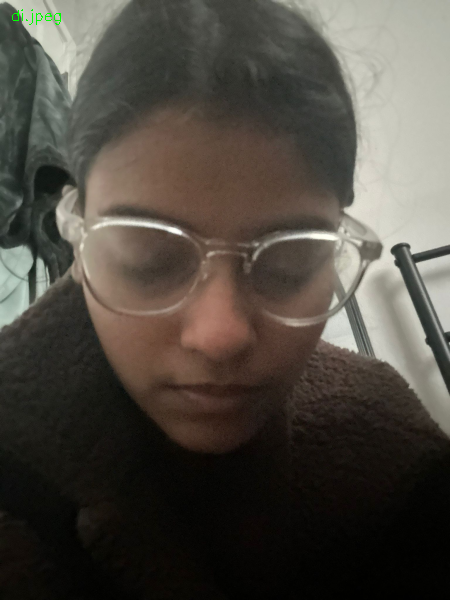

No alert triggered or alert sound files not found.
Processing complete!


In [ ]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display

# Function to play alert sound in Colab
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

# Function for emergency alert
def trigger_emergency_alert():
    print("🚨 EMERGENCY ALERT TRIGGERED! 🚨")

    # Option 1: Display a very visible alert in the notebook
    from IPython.display import HTML, display
    emergency_html = """
    <div style="background-color: red; color: white; padding: 20px; font-size: 24px; text-align: center; animation: blinker 1s linear infinite;">
    ⚠️ EMERGENCY! DRIVER SEVERELY DROWSY! TAKE IMMEDIATE ACTION! ⚠️
    </div>
    <style>
    @keyframes blinker {
      50% {
        opacity: 0;
      }
    }
    </style>
    """
    display(HTML(emergency_html))

    # Option 2: Play a loud emergency sound
    emergency_sound_path = "/content/emergency_alert.mp3"
    if os.path.exists(emergency_sound_path):
        display(Audio(emergency_sound_path, autoplay=True))

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# Single image path to process
image_path = "/content/di.jpeg"  # Change this to your specific image path

# Set your custom alert sound file path here
normal_alert_path = "/content/alert.mp3"  # For regular alerts
emergency_alert_path = "/content/emergency_alert.mp3"  # For emergency situations

# First install pydub - you need to run this first
!pip install pydub

# Then generate the emergency sound
from pydub import AudioSegment
from pydub.generators import Sine

# Generate a regular alert sound
beep = Sine(440).to_audio_segment(duration=1000)
beep = beep * 3  # Make it louder
beep.export("/content/alert.mp3", format="mp3")

# Generate a more urgent emergency sound
emergency = Sine(880).to_audio_segment(duration=300)
emergency = emergency * 4  # Make it even louder
for _ in range(5):  # Repeat the tone for urgency
    emergency += Sine(988).to_audio_segment(duration=300) * 4
emergency.export("/content/emergency_alert.mp3", format="mp3")

# Parameters for normal and emergency thresholds
EYE_AR_THRESH = 0.25  # Normal drowsiness threshold
EMERGENCY_EYE_AR_THRESH = 0.2  # Severe drowsiness threshold
YAWN_THRESH = 30  # Normal yawn threshold
EMERGENCY_YAWN_THRESH = 20  # Very large yawn threshold
COUNTER = 0

print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Check if image exists
if not os.path.exists(image_path):
    print(f"Image not found at: {image_path}")
    print("Please make sure the image exists at the specified path.")
    exit()

print(f"\nProcessing image: {image_path}")

# Read the image
frame = cv2.imread(image_path)
if frame is None:
    print(f"Failed to read image from: {image_path}")
    print("The file may be corrupted or in an unsupported format.")
    exit()

frame = imutils.resize(frame, width=450)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Detect faces
rects = detector.detectMultiScale(gray, scaleFactor=1.1,
                                 minNeighbors=5, minSize=(30, 30),
                                 flags=cv2.CASCADE_SCALE_IMAGE)

# Draw filename on image
cv2.putText(frame, os.path.basename(image_path), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

normal_alert_triggered = False
emergency_alert_triggered = False

if len(rects) == 0:
    print("No faces detected in the image.")
else:
    print(f"Detected {len(rects)} face(s) in the image.")

for (x, y, w, h) in rects:
    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    eye = final_ear(shape)
    ear = eye[0]
    leftEye = eye[1]
    rightEye = eye[2]

    distance = lip_distance(shape)

    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)
    cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
    cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

    lip = shape[48:60]
    cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

    # Debug values
    print(f"Detected EAR: {ear:.4f}, Normal Threshold: {EYE_AR_THRESH:.4f}, Emergency Threshold: {EMERGENCY_EYE_AR_THRESH:.4f}")
    print(f"Detected lip distance: {distance:.4f}, Normal Threshold: {YAWN_THRESH:.4f}, Emergency Threshold: {EMERGENCY_YAWN_THRESH:.4f}")

    # Check for emergency conditions first (higher priority)
    if ear < EMERGENCY_EYE_AR_THRESH or distance > EMERGENCY_YAWN_THRESH:
        cv2.putText(frame, "!!! EMERGENCY ALERT !!!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        emergency_alert_triggered = True

        if ear < EMERGENCY_EYE_AR_THRESH:
            print(f"EMERGENCY! Severe drowsiness detected! Eye Aspect Ratio: {ear:.2f}")
            cv2.putText(frame, "SEVERE DROWSINESS!", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        if distance > EMERGENCY_YAWN_THRESH:
            print(f"EMERGENCY! Extreme yawning detected! Lip Distance: {distance:.2f}")
            cv2.putText(frame, "EXTREME YAWNING!", (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Check for normal alert conditions
    elif ear < EYE_AR_THRESH or distance > YAWN_THRESH:
        normal_alert_triggered = True

        if ear < EYE_AR_THRESH:
            cv2.putText(frame, "Drowsiness Alert", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Drowsiness detected! Eye Aspect Ratio: {ear:.2f}")

        if distance > YAWN_THRESH:
            cv2.putText(frame, "Yawn Alert", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            print(f"Yawn detected! Lip Distance: {distance:.2f}")

    cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# In Google Colab, we need to use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow
cv2_imshow(frame)

# Handle alerts based on priority
if emergency_alert_triggered:
    trigger_emergency_alert()
elif normal_alert_triggered and os.path.exists(normal_alert_path):
    play_alert_in_colab(normal_alert_path)
else:
    print("No alert triggered or alert sound files not found.")

print("Processing complete!")

-> Loading the predictor and detector...
No faces detected.


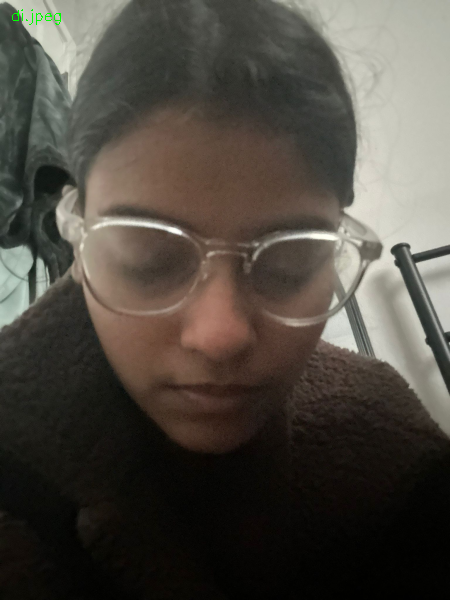

✅ Output image saved as: output_detected.jpg
No alert triggered or alert sound files not found.


In [ ]:
# Install and import necessary libraries
!pip install pydub

from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display, HTML
from pydub import AudioSegment
from pydub.generators import Sine
from google.colab.patches import cv2_imshow

# --- Function to play alert in Colab ---
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

# --- Function to display emergency alert in Colab ---
def trigger_emergency_alert():
    print("🚨 EMERGENCY ALERT TRIGGERED! 🚨")
    emergency_html = """
    <div style="background-color: red; color: white; padding: 20px; font-size: 24px; text-align: center; animation: blinker 1s linear infinite;">
    ⚠️ EMERGENCY! DRIVER SEVERELY DROWSY! TAKE IMMEDIATE ACTION! ⚠️
    </div>
    <style>
    @keyframes blinker {
      50% {
        opacity: 0;
      }
    }
    </style>
    """
    display(HTML(emergency_html))
    if os.path.exists("/content/emergency_alert.mp3"):
        display(Audio("/content/emergency_alert.mp3", autoplay=True))

# --- EAR and lip calculation helpers ---
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]
    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)
    return ((leftEAR + rightEAR) / 2.0, leftEye, rightEye)

def lip_distance(shape):
    top_lip = np.concatenate((shape[50:53], shape[61:64]))
    low_lip = np.concatenate((shape[56:59], shape[65:68]))
    return abs(np.mean(top_lip, axis=0)[1] - np.mean(low_lip, axis=0)[1])

# --- Paths and thresholds ---
image_path = "/content/di.jpeg"
normal_alert_path = "/content/alert.mp3"
emergency_alert_path = "/content/emergency_alert.mp3"

EYE_AR_THRESH = 0.25
EMERGENCY_EYE_AR_THRESH = 0.2
YAWN_THRESH = 30
EMERGENCY_YAWN_THRESH = 20
COUNTER = 0

# --- Generate alert sounds ---
beep = Sine(440).to_audio_segment(duration=1000) * 3
beep.export(normal_alert_path, format="mp3")

emergency = Sine(880).to_audio_segment(duration=300) * 4
for _ in range(5):
    emergency += Sine(988).to_audio_segment(duration=300) * 4
emergency.export(emergency_alert_path, format="mp3")

# --- Load models ---
print("-> Loading the predictor and detector...")
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# --- Load image ---
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found at: {image_path}")

frame = cv2.imread(image_path)
if frame is None:
    raise ValueError(f"Failed to read image from: {image_path}")

frame = imutils.resize(frame, width=450)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rects = detector.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

normal_alert_triggered = False
emergency_alert_triggered = False

cv2.putText(frame, os.path.basename(image_path), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

if len(rects) == 0:
    print("No faces detected.")
else:
    print(f"Detected {len(rects)} face(s).")

    for (x, y, w, h) in rects:
        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        ear, leftEye, rightEye = final_ear(shape)
        distance = lip_distance(shape)

        cv2.drawContours(frame, [cv2.convexHull(leftEye)], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [cv2.convexHull(rightEye)], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [shape[48:60]], -1, (0, 255, 0), 1)

        print(f"EAR: {ear:.4f} | Lip Distance: {distance:.4f}")

        if ear < EMERGENCY_EYE_AR_THRESH or distance > EMERGENCY_YAWN_THRESH:
            emergency_alert_triggered = True
            cv2.putText(frame, "!!! EMERGENCY ALERT !!!", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            if ear < EMERGENCY_EYE_AR_THRESH:
                cv2.putText(frame, "SEVERE DROWSINESS!", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            if distance > EMERGENCY_YAWN_THRESH:
                cv2.putText(frame, "EXTREME YAWNING!", (10, 90),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        elif ear < EYE_AR_THRESH or distance > YAWN_THRESH:
            normal_alert_triggered = True
            if ear < EYE_AR_THRESH:
                cv2.putText(frame, "Drowsiness Alert", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            if distance > YAWN_THRESH:
                cv2.putText(frame, "Yawn Alert", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# --- Display and save output ---
cv2_imshow(frame)
cv2.imwrite("/content/output_detected-di.jpg", frame)
print("✅ Output image saved as: output_detected.jpg")

# --- Trigger alerts ---
if emergency_alert_triggered:
    trigger_emergency_alert()
elif normal_alert_triggered and os.path.exists(normal_alert_path):
    play_alert_in_colab(normal_alert_path)
else:
    print("No alert triggered or alert sound files not found.")


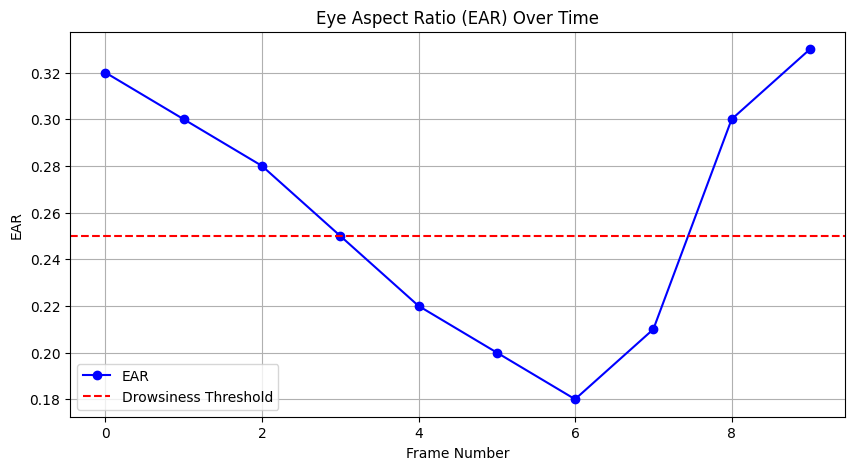

In [ ]:
import matplotlib.pyplot as plt

# Example EAR data over time (frames)
frames = list(range(10))
ear_values = [0.32, 0.30, 0.28, 0.25, 0.22, 0.20, 0.18, 0.21, 0.30, 0.33]

plt.figure(figsize=(10,5))
plt.plot(frames, ear_values, marker='o', linestyle='-', color='blue', label='EAR')

plt.axhline(y=0.25, color='red', linestyle='--', label='Drowsiness Threshold')

plt.title("Eye Aspect Ratio (EAR) Over Time")
plt.xlabel("Frame Number")
plt.ylabel("EAR")
plt.legend()
plt.grid(True)

plt.savefig("ear_plot.png", dpi=300)
plt.show()


In [ ]:
# Import necessary libraries
from scipy.spatial import distance as dist
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import os
from IPython.display import Audio, display
import datetime

# Function to play alert sound in Colab
def play_alert_in_colab(audio_path):
    print("⚠️ ALERT: Drowsiness/Yawn detected!")
    display(Audio(audio_path, autoplay=True))

# Function for emergency alert
def trigger_emergency_alert():
    print("🚨 EMERGENCY ALERT TRIGGERED! 🚨")

    # Option 1: Display a very visible alert in the notebook
    from IPython.display import HTML, display
    emergency_html = """
    <div style="background-color: red; color: white; padding: 20px; font-size: 24px; text-align: center; animation: blinker 1s linear infinite;">
    ⚠️ EMERGENCY! DRIVER SEVERELY DROWSY! TAKE IMMEDIATE ACTION! ⚠️
    </div>
    <style>
    @keyframes blinker {
      50% {
        opacity: 0;
      }
    }
    </style>
    """
    display(HTML(emergency_html))

    # Option 2: Play a loud emergency sound
    emergency_sound_path = "/content/emergency_alert.mp3"
    if os.path.exists(emergency_sound_path):
        display(Audio(emergency_sound_path, autoplay=True))

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def final_ear(shape):
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0
    return (ear, leftEye, rightEye)

def lip_distance(shape):
    top_lip = shape[50:53]
    top_lip = np.concatenate((top_lip, shape[61:64]))

    low_lip = shape[56:59]
    low_lip = np.concatenate((low_lip, shape[65:68]))

    top_mean = np.mean(top_lip, axis=0)
    low_mean = np.mean(low_lip, axis=0)

    distance = abs(top_mean[1] - low_mean[1])
    return distance

# Single image path to process
image_path = "/content/nn.png"  # Change this to your specific image path

# Set your custom alert sound file path here
normal_alert_path = "/content/alert.mp3"  # For regular alerts
emergency_alert_path = "/content/emergency_alert.mp3"  # For emergency situations

# First install pydub - you need to run this first
!pip install pydub

# Then generate the emergency sound
from pydub import AudioSegment
from pydub.generators import Sine

# Generate a regular alert sound
beep = Sine(440).to_audio_segment(duration=1000)
beep = beep * 3  # Make it louder
beep.export("/content/alert.mp3", format="mp3")

# Generate a more urgent emergency sound
emergency = Sine(880).to_audio_segment(duration=300)
emergency = emergency * 4  # Make it even louder
for _ in range(5):  # Repeat the tone for urgency
    emergency += Sine(988).to_audio_segment(duration=300) * 4
emergency.export("/content/emergency_alert.mp3", format="mp3")

# Parameters for normal and emergency thresholds
EYE_AR_THRESH = 0.25  # Normal drowsiness threshold
EMERGENCY_EYE_AR_THRESH = 0.2  # Severe drowsiness threshold
YAWN_THRESH = 30  # Normal yawn threshold
EMERGENCY_YAWN_THRESH = 20  # Very large yawn threshold
COUNTER = 0

print("-> Loading the predictor and detector...")
# Try multiple face detectors for better results
detector_haar = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
detector_dlib = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Check if image exists
if not os.path.exists(image_path):
    print(f"Image not found at: {image_path}")
    print("Please make sure the image exists at the specified path.")
    exit()

print(f"\nProcessing image: {image_path}")

# Read the image
frame = cv2.imread(image_path)
if frame is None:
    print(f"Failed to read image from: {image_path}")
    print("The file may be corrupted or in an unsupported format.")
    exit()

# Improved preprocessing for better face detection
frame = imutils.resize(frame, width=450)
orig_frame = frame.copy()  # Keep a copy of the original frame
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Improve contrast
gray = cv2.equalizeHist(gray)

# Try to detect faces with multiple methods
rects_haar = detector_haar.detectMultiScale(gray,
                                     scaleFactor=1.05,  # Reduced from 1.1
                                     minNeighbors=3,    # Reduced from 5
                                     minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE)

rects_dlib = detector_dlib(gray, 1)  # The second parameter increases detection sensitivity

# Draw filename on image
cv2.putText(frame, os.path.basename(image_path), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

normal_alert_triggered = False
emergency_alert_triggered = False

# Convert dlib rects to OpenCV format if needed
rects = []
if len(rects_haar) > 0:
    rects = rects_haar
    print(f"Detected {len(rects)} face(s) using Haar Cascade.")
elif len(rects_dlib) > 0:
    for rect in rects_dlib:
        x = rect.left()
        y = rect.top()
        w = rect.right() - rect.left()
        h = rect.bottom() - rect.top()
        rects.append((x, y, w, h))
    print(f"Detected {len(rects)} face(s) using dlib.")
else:
    print("No faces detected with default parameters. Trying with more relaxed parameters...")
    # Try with even more relaxed parameters
    rects_haar = detector_haar.detectMultiScale(gray,
                                         scaleFactor=1.01,
                                         minNeighbors=1,
                                         minSize=(20, 20),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    if len(rects_haar) > 0:
        rects = rects_haar
        print(f"Detected {len(rects)} face(s) with relaxed parameters.")
    else:
        # Last resort: just use the whole image as a "face"
        print("No faces detected. Using the whole image as a face region.")
        height, width = gray.shape
        rects = [(0, 0, width, height)]

# Process each detected face
for (x, y, w, h) in rects:
    # Draw rectangle around the face
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))

    try:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        eye = final_ear(shape)
        ear = eye[0]
        leftEye = eye[1]
        rightEye = eye[2]

        distance = lip_distance(shape)

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        lip = shape[48:60]
        cv2.drawContours(frame, [lip], -1, (0, 255, 0), 1)

        # Debug values
        print(f"Detected EAR: {ear:.4f}, Normal Threshold: {EYE_AR_THRESH:.4f}, Emergency Threshold: {EMERGENCY_EYE_AR_THRESH:.4f}")
        print(f"Detected lip distance: {distance:.4f}, Normal Threshold: {YAWN_THRESH:.4f}, Emergency Threshold: {EMERGENCY_YAWN_THRESH:.4f}")

        # Check for emergency conditions first (higher priority)
        if ear < EMERGENCY_EYE_AR_THRESH or distance > EMERGENCY_YAWN_THRESH:
            cv2.putText(frame, "!!! EMERGENCY ALERT !!!", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            emergency_alert_triggered = True

            if ear < EMERGENCY_EYE_AR_THRESH:
                print(f"EMERGENCY! Severe drowsiness detected! Eye Aspect Ratio: {ear:.2f}")
                cv2.putText(frame, "SEVERE DROWSINESS!", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            if distance > EMERGENCY_YAWN_THRESH:
                print(f"EMERGENCY! Extreme yawning detected! Lip Distance: {distance:.2f}")
                cv2.putText(frame, "EXTREME YAWNING!", (10, 90),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Check for normal alert conditions
        elif ear < EYE_AR_THRESH or distance > YAWN_THRESH:
            normal_alert_triggered = True

            if ear < EYE_AR_THRESH:
                cv2.putText(frame, "Drowsiness Alert", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                print(f"Drowsiness detected! Eye Aspect Ratio: {ear:.2f}")

            if distance > YAWN_THRESH:
                cv2.putText(frame, "Yawn Alert", (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                print(f"Yawn detected! Lip Distance: {distance:.2f}")

        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, "YAWN: {:.2f}".format(distance), (300, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    except Exception as e:
        print(f"Error processing facial landmarks: {e}")
        # If facial landmark detection fails, still show the frame with face rectangle
        cv2.putText(frame, "Landmark detection failed", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# In Google Colab, we need to use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow
cv2_imshow(frame)

# Save the output image
output_dir = "/content/output"
# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create a filename with timestamp to avoid overwriting
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
if emergency_alert_triggered:
    output_filename = f"emergency_alert_{timestamp}_{os.path.basename(image_path)}"
elif normal_alert_triggered:
    output_filename = f"alert_{timestamp}_{os.path.basename(image_path)}"
else:
    output_filename = f"processed_{timestamp}_{os.path.basename(image_path)}"

output_path = os.path.join(output_dir, output_filename)
cv2.imwrite(output_path, frame)
print(f"Output image saved to: {output_path}")

# Handle alerts based on priority
if emergency_alert_triggered:
    trigger_emergency_alert()
elif normal_alert_triggered and os.path.exists(normal_alert_path):
    play_alert_in_colab(normal_alert_path)
else:
    print("No alert triggered or alert sound files not found.")

print("Processing complete!")

-> Loading the predictor and detector...

Processing image: /content/nn.png


error: OpenCV(4.11.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'
